# Overview of Deep Learning using PyTorch

### Loading Libraries

In [1]:
# Numerical Computing
import math
import numpy as np

# Data Manipulation
import pandas as pd

# Data Visualization 
import matplotlib.pyplot as plt

# PyTorch
import torch
import torchaudio
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("Torchaudio version:", torchaudio.__version__)

print("GPU Existance:", torch.cuda.is_available())

PyTorch version: 2.5.1
Torchvision version: 0.20.1
Torchaudio version: 2.5.1
GPU Existance: False


### Simple Tensors

In [3]:
points = torch.tensor([1.0, 4.0, 2.0, 1.0, 3.0, 5.0])

In [4]:
points[0]

tensor(1.)

In [5]:
points.shape

torch.Size([6])

In [6]:
points.storage

<bound method Tensor.storage of tensor([1., 4., 2., 1., 3., 5.])>

### PyTorch Modules

#### `torch.nn`

In [7]:
weights = torch.randn(256, 4) / math.sqrt(256)

In [8]:
weights.requires_grad_()

tensor([[-0.1346, -0.0698,  0.1033,  0.0662],
        [ 0.1340,  0.0318,  0.0676, -0.0182],
        [ 0.0436,  0.0436, -0.0068, -0.0644],
        ...,
        [ 0.1246, -0.0227,  0.1562, -0.0856],
        [-0.0402, -0.0930,  0.1501, -0.0128],
        [-0.0266, -0.0851,  0.0863,  0.0487]], requires_grad=True)

In [9]:
bias = torch.zeros(4, requires_grad=True)

### Training a Neural Network using PyTorch

In [10]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1)
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64) # 4608 is basically 12 X 12 X 32
        self.fc2 = nn.Linear(64, 10)
 
    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)
        return op

In [15]:
model = nn.Sequential(
    nn.Conv2d(1, 16, 3, 1),
    nn.ReLU(),
    nn.Conv2d(16, 32, 3, 1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout2d(0.10),
    nn.Flatten(),
    nn.Linear(4608, 64),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1)
)

### Training Model Function

##### `nll` is the negative likelihood loss

In [16]:
def train(model, device, train_dataloader, optim, epoch):
    model.train()
    for b_i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        pred_prob = model(X)
        loss = F.nll_loss(pred_prob, y) 
        loss.backward()
        optim.step()
        if b_i % 10 == 0:
            print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                epoch, b_i * len(X), len(train_dataloader.dataset),
                100. * b_i / len(train_dataloader), loss.item()))

#### `Test Model Performance`

In [17]:
def test(model, device, test_dataloader):
    model.eval()
    loss = 0
    success = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            # loss summed across the batch
            loss += F.nll_loss(pred_prob, y, reduction='sum').item()  
            # Use ArgMax to get the most likely prediction
            pred = pred_prob.argmax(dim=1, keepdim=True)  
            success += pred.eq(y.view_as(pred)).sum().item()

    loss /= len(test_dataloader.dataset)

    print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, success, len(test_dataloader.dataset),
        100. * success / len(test_dataloader.dataset)))

### Dataset Loading

1. The `Mean` & `Standard Deviation` values are calculated as the mean of all pixel values of all images in the Training Dataset.

In [18]:
train_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,))])), # train_X.mean()/256. and train_X.std()/256.
    batch_size=32, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,)) 
                   ])),
    batch_size=500, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden




00%|██████████████████████████████████████| 9.91M/9.91M [00:05<00:00, 1.77MB/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden




00%|███████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 384kB/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden




00%|██████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 2.70MB/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 1.09MB/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



### Placing Optimizer & Running Training Epochs

In [19]:
torch.manual_seed(0)
device = torch.device("cpu")

model = ConvNet()
optimizer = optim.Adadelta(model.parameters(), lr=0.5)

### Training Model 

In [20]:
for epoch in range(1, 3):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

/Users/isisromero/anaconda3/envs/Pytorch/lib/python3.11/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [0/60000 (0%)]	 training loss: 2.301478
epoch: 1 [320/60000 (1%)]	 training loss: 1.744152
epoch: 1 [640/60000 (1%)]	 training loss: 1.234419
epoch: 1 [960/60000 (2%)]	 training loss: 0.831864
epoch: 1 [1280/60000 (2%)]	 training loss: 0.969942
epoch: 1 [1600/60000 (3%)]	 training loss: 0.553293
epoch: 1 [1920/60000 (3%)]	 training loss: 0.627297
epoch: 1 [2240/60000 (4%)]	 training loss: 0.533486
epoch: 1 [2560/60000 (4%)]	 training loss: 0.450610
epoch: 1 [2880/60000 (5%)]	 training loss: 0.363707
epoch: 1 [3200/60000 (5%)]	 training loss: 0.340398
epoch: 1 [3520/60000 (6%)]	 training loss: 0.372920
epoch: 1 [3840/60000 (6%)]	 training loss: 0.330355
epoch: 1 [4160/60000 (7%)]	 training loss: 0.446091
epoch: 1 [4480/60000 (7%)]	 training loss: 0.415660
epoch: 1 [4800/60000 (8%)]	 training loss: 0.467097
epoch: 1 [5120/60000 (9%)]	 training loss: 0.183409
epoch: 1 [5440/60000 (9%)]	 training loss: 0.303824
epoch: 1 [5760/60000 (10%)]	 training loss: 0.131208
epoch: 1 [6080/60

### Executing `Inference` on `Trained Model`

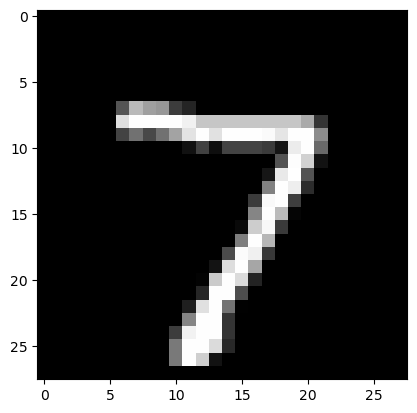

In [21]:
test_samples = enumerate(test_dataloader)
b_i, (sample_data, sample_targets) = next(test_samples)

plt.imshow(sample_data[0][0], cmap='gray', interpolation='none')
plt.show()

In [22]:
print(f"Model prediction is : {model(sample_data).data.max(1)[1][0]}")

print(f"Ground truth is : {sample_targets[0]}")

Model prediction is : 7
Ground truth is : 7
